In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt


In [2]:
# Load the data from the CSV file
df = pd.read_csv("./data/train_data-cleaned.csv")
df_test = pd.read_csv("./data/test_data-cleaned.csv")

# Display the first few rows to verify the data was loaded correctly
df.head(5)

,subtype,bedroomCount,postCode,habitableSurface,hasDressingRoom,buildingCondition,buildingConstructionYear,facedeCount,hasHeatPump,hasPhotovoltaicPanels,...,kitchenType,landSurface,parkingCountOutdoor,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,terraceSurface,price,epc_kwh
0,14,3,3365,150,0,1,2010,3,0,0,...,5,324,1,0,2,0,0,0,475000,150
1,14,4,3339,172,0,1,1979,3,0,0,...,5,160,0,0,3,0,0,0,589000,150
2,16,1,1815,68,0,3,1979,3,0,0,...,5,0,0,0,1,0,0,0,130000,225
3,16,2,2815,95,0,3,2003,2,0,0,...,5,0,1,0,1,0,0,6,295000,225
4,16,1,2946,63,0,5,1969,3,0,0,...,8,0,0,0,1,0,0,0,154000,500


Prepare for regression + Standardize scales

In [3]:
price_correlations = df.corr()['price'].abs().sort_values(ascending=False)
features = price_correlations.index.tolist()[1:]

target = 'price'

x_train = df[features]
y_train = df[target]

# Split the dataset
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_test = df_test[features]
y_test = df_test[target]

---
## Option 1: Linear Regression Coefficients (for linear relationships)

<Axes: title={'center': 'Linear Regression Feature Importance'}>

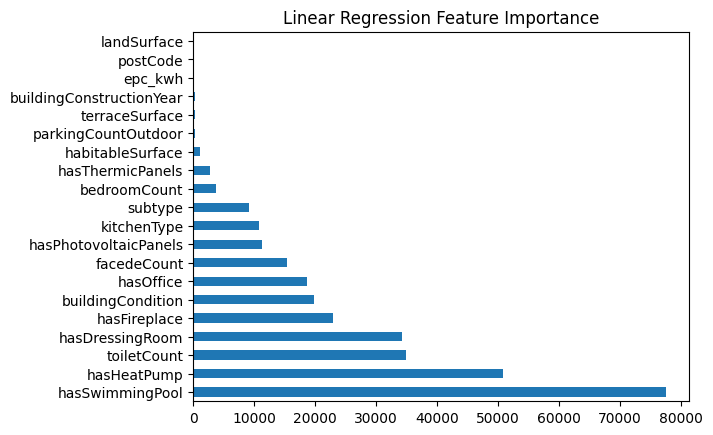

In [4]:
lr = LinearRegression()
lr.fit(x_train, y_train)

# Get importance from coefficients (absolute values give relative importance)
importance = pd.Series(np.abs(lr.coef_), index=features)
importance.sort_values(ascending=False).plot(kind='barh', title='Linear Regression Feature Importance')

## Evaluate Model

In [5]:
y_pred = lr.predict(x_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MAPE:", np.mean(np.abs((y_test - y_pred) / y_test)) * 100, "%")
print("MAE:", np.mean(np.abs(y_test - y_pred)))

RMSE: 138097.37829569564
R² Score: 0.6901066249144021
MAPE: 24.769832683649724 %
MAE: 88626.8292808557


---

## Option 2: XGBoost
XGBoost (eXtreme Gradient Boosting) is another powerful ensemble learning technique that often outperforms both linear regression and random forest models. It uses gradient boosting with regularization to reduce overfitting and improve performance.

Key advantages of XGBoost:
- High performance and efficient computation
- Regularization to prevent overfitting
- Handles missing values automatically
- Supports parallel processing
- Offers built-in cross-validation

For our housing price prediction task, XGBoost can capture complex non-linear relationships while maintaining good generalization performance.

<Axes: title={'center': 'XGBoost Feature Importance'}>

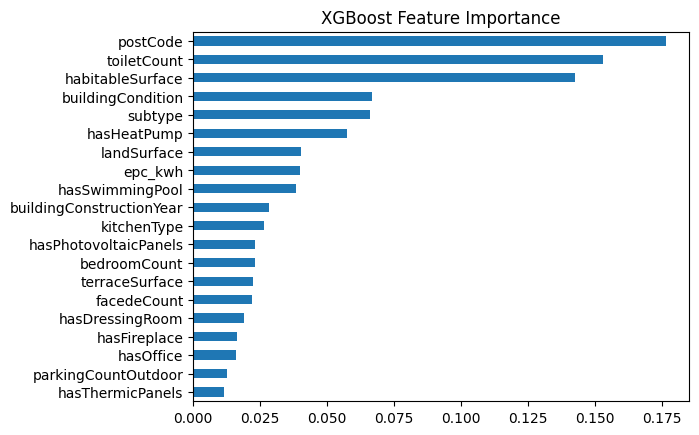

In [6]:

# Initialize XGBoost model with good default parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=7,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=0.6,
    objective='reg:squarederror',
    random_state=42
)

# # Finetuning with GridSearchCV,
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'min_child_weight': [1, 3, 5]
# }
# grid_search = GridSearchCV(
#     estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )
# grid_search.fit(x_train, y_train)
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

# Train the model
xgb_model.fit(x_train, y_train)

xgb_model.save_model('models/xgb_model.json')

# Get feature importance
importance = pd.Series(xgb_model.feature_importances_, index=features)
importance.sort_values(ascending=True).plot(
    kind='barh', 
    title='XGBoost Feature Importance'
)

### Evaluate Model

In [7]:
# Make predictions
y_pred = xgb_model.predict(x_test)

# Evaluate the model
print("XGBoost Performance Metrics:")
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred) * 100, "%")
print("MAE:", mean_absolute_error(y_test, y_pred))



XGBoost Performance Metrics:
RMSE: 113325.1484375
R² Score: 0.791313648223877
MAPE: 18.1004136800766 %
MAE: 69674.1171875


---

## Option 3 : Neural Network

d:\BeCode\becode_projects\immo-eliza-machine-learning-BlueHowl\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 210835734528.0000 - mae: 389241.3438 - val_loss: 180639563776.0000 - val_mae: 361687.7812
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 143433646080.0000 - mae: 320329.5312 - val_loss: 45870149632.0000 - val_mae: 167228.3906
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35314700288.0000 - mae: 136264.6406 - val_loss: 17751353344.0000 - val_mae: 88929.4219
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20031539200.0000 - mae: 97073.7188 - val_loss: 15547051008.0000 - val_mae: 81620.1953
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19022391296.0000 - mae: 92966.6953 - val_loss: 14861369344.0000 - val_mae: 81080.2656
Epoch 6/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18157178880.0000 - mae: 89284.4922 - val_loss: 14314593280.0000 - val_mae: 77964.6250
Epoch 7/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 17471563776.0000 - mae: 86140.7109 - val_loss: 136736122

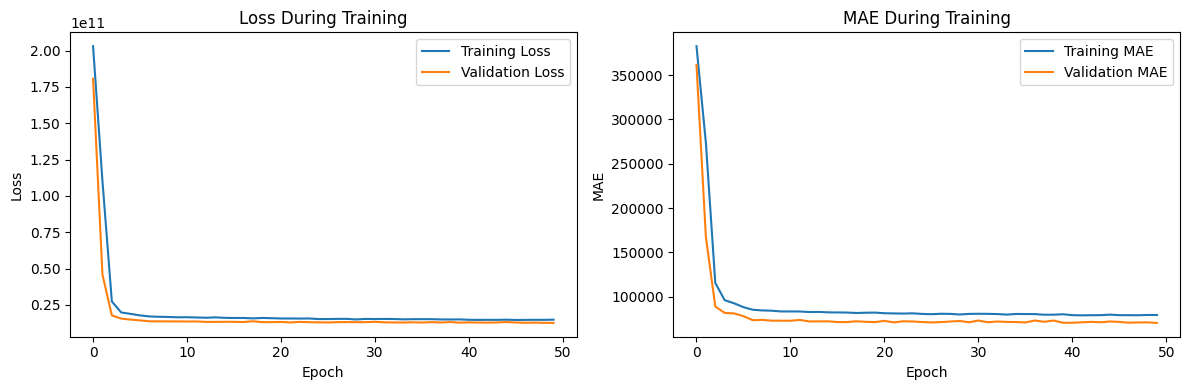

In [8]:
# Standardize features for better neural network performance
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Build the neural network model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(len(features),)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
nn_model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss='mse',
    metrics=['mae']
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = nn_model.fit(
    x_train_scaled, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
y_pred = nn_model.predict(x_test_scaled).flatten()
print("\nNeural Network Performance Metrics:")
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred) * 100, "%")
print("MAE:", mean_absolute_error(y_test, y_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

---

## Option 4 : K-nearest neighbour

In [9]:
# Scale the features for better KNN performance
scaler_knn = StandardScaler()
x_train_scaled_knn = scaler_knn.fit_transform(x_train)
x_test_scaled_knn = scaler_knn.transform(x_test)

# Simple KNN model with default parameters
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(x_train_scaled_knn, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(x_test_scaled_knn)
print("KNN Default Performance Metrics:")
print("RMSE:", root_mean_squared_error(y_test, y_pred_knn))
print("R² Score:", r2_score(y_test, y_pred_knn))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_knn) * 100, "%")
print("MAE:", mean_absolute_error(y_test, y_pred_knn))

# Find optimal hyperparameters using GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 is Manhattan, p=2 is Euclidean
}

# Only use a subset of data for GridSearchCV to make it faster
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Train on a sample for speed (optional)
grid_search.fit(x_train_scaled_knn[:10000], y_train[:10000])
best_params = grid_search.best_params_
print(f"\nBest parameters: {best_params}")

# Train the optimized model
best_knn = KNeighborsRegressor(**best_params)
best_knn.fit(x_train_scaled_knn, y_train)
y_pred_best_knn = best_knn.predict(x_test_scaled_knn)

# Evaluate the optimized model
print("\nOptimized KNN Performance Metrics:")
print("RMSE:", root_mean_squared_error(y_test, y_pred_best_knn))
print("R² Score:", r2_score(y_test, y_pred_best_knn))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_best_knn) * 100, "%")
print("MAE:", mean_absolute_error(y_test, y_pred_best_knn))

KNN Default Performance Metrics:
RMSE: 142794.29965973448
R² Score: 0.668668164873276
MAPE: 23.388282480218272 %
MAE: 89268.76518660868

Best parameters: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

Optimized KNN Performance Metrics:
RMSE: 134389.24675167556
R² Score: 0.7065254375285547
MAPE: 21.145370749001856 %
MAE: 81472.69170423782
